In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

In [2]:
model = models.vgg19(pretrained=True).features

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 101MB/s]


In [3]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.chosen_features = ['0', '5', '10', '19', '28'] # first conv after ReLU
    self.model = models.vgg19(pretrained=True).features[:29]

  def forward(self, x):
    features = []
    for layer_num, layer in enumerate(self.model):
      x = layer(x)
      if str(layer_num) in self.chosen_features:
        features.append(x)
    return features

## Images

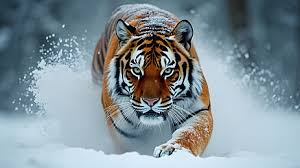

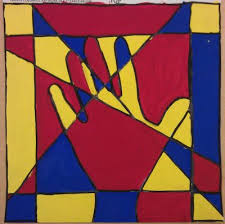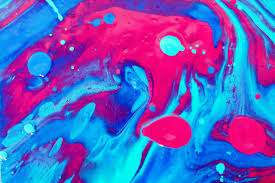

## Initialization and util functions

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 356

loader = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[], std=[])
])

def load_image(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0)
  return image.to(device)


model = VGG().to(device).eval()


path = "/content/"
original_img = load_image(path+"tiger.png")
style_img = load_image(path+"art1.png")
style_img = load_image(path+"art2.png")
# generated = torch.randn(original_img.data.size(), device=device, requires_grad=True)
generated = original_img.clone().requires_grad_(True)


# Hyperparameters
total_steps = 6000
learning_rate = 0.001
alpha = 1    # loss for original image
beta = 0.01  # loss for style image

optimizer = optim.Adam([generated], lr=learning_rate)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
for step in range(total_steps):
  generated_features = model(generated)
  original_img_features = model(original_img)
  style_features = model(style_img)

  style_loss = original_loss = 0

  for gen_feature, orig_feature, style_feature in zip(
      generated_features, original_img_features, style_features
  ):
    batch_size, channel, height, width = gen_feature.size()
    original_loss += torch.mean((gen_feature - orig_feature)**2)

    # compute Gram Matrix
    G = gen_feature.view(channel, height*width).mm(
        gen_feature.view(channel, height*width).t()
    )

    A = style_feature.view(channel, height*width).mm(
        style_feature.view(channel, height*width).t()
    )

    style_loss += torch.mean((G - A)**2)

  total_loss = alpha*original_loss + beta*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if step%200 == 0:
    print(total_loss)
    save_image(generated, f"/content/generated.png")

    # Compute Gram Matrix

tensor(2091878.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(537041.4375, device='cuda:0', grad_fn=<AddBackward0>)
tensor(219166.7188, device='cuda:0', grad_fn=<AddBackward0>)
tensor(144551.7500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(93901.2812, device='cuda:0', grad_fn=<AddBackward0>)
tensor(56510.2070, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33359.1680, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20844.2559, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14207.3066, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10446.6475, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8131.1538, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6594.0684, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

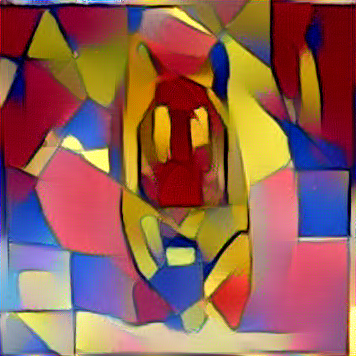

In [12]:
Image.open(f"/content/generated.png")

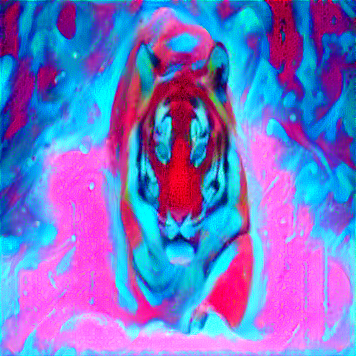

In [15]:
Image.open(f"/content/generated.png")

After 6000 steps on art1.png

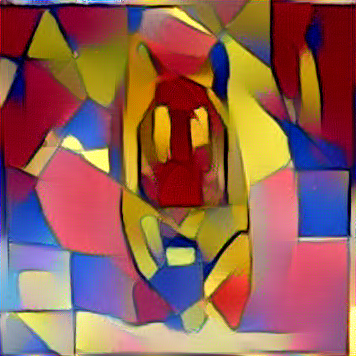

After 1200 steps on art2.png

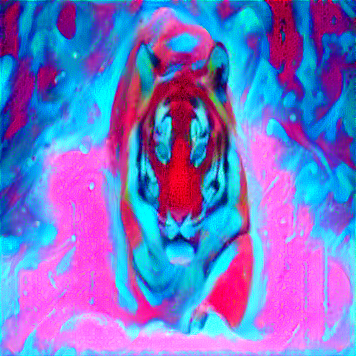